In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
docs = pd.read_csv("Doctor.csv")

<IPython.core.display.Javascript object>

In [44]:
docs.head()

,doctor,children,access,health,access_groups
0,0,1,0.50,0.495,True
1,1,3,0.17,0.520,False
2,0,4,0.42,-1.227,True
3,0,2,0.33,-1.524,False
4,11,1,0.67,0.173,True


<IPython.core.display.Javascript object>

In [6]:
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   doctor    485 non-null    int64  
 1   children  485 non-null    int64  
 2   access    485 non-null    float64
 3   health    485 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 15.3 KB


<IPython.core.display.Javascript object>

In [7]:
docs.isna().sum()

doctor      0
children    0
access      0
health      0
dtype: int64

<IPython.core.display.Javascript object>

In [8]:
docs["health"].describe()

count    485.000000
mean      -0.000041
std        1.433520
min       -1.524000
25%       -1.066000
50%       -0.421000
75%        0.657000
max        7.217000
Name: health, dtype: float64

<IPython.core.display.Javascript object>

In [9]:
docs["access"].describe()

count    485.000000
mean       0.381175
std        0.186108
min        0.000000
25%        0.250000
50%        0.350000
75%        0.500000
max        0.920000
Name: access, dtype: float64

<IPython.core.display.Javascript object>

In [10]:
docs["access_groups"] = docs["access"] > docs["access"].mean()

<IPython.core.display.Javascript object>

In [11]:
docs.head()

,doctor,children,access,health,access_groups
0,0,1,0.50,0.495,True
1,1,3,0.17,0.520,False
2,0,4,0.42,-1.227,True
3,0,2,0.33,-1.524,False
4,11,1,0.67,0.173,True


<IPython.core.display.Javascript object>

In [12]:
good_access = docs[docs["access_groups"] == True]
bad_access = docs[docs["access_groups"] == False]

<IPython.core.display.Javascript object>

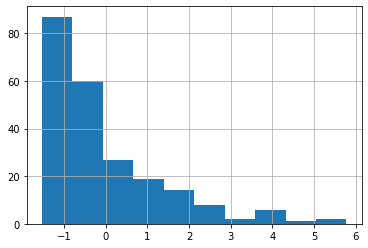

<IPython.core.display.Javascript object>

In [45]:
good_access["health"].hist()

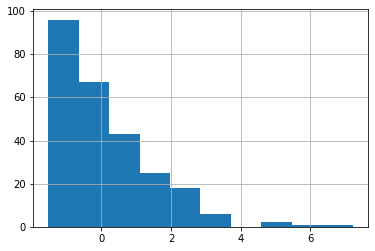

<IPython.core.display.Javascript object>

In [46]:
bad_access["health"].hist()

In [15]:
stats.mannwhitneyu(good_access["health"], bad_access["health"])

MannwhitneyuResult(statistic=26238.0, pvalue=0.02452308880644759)

<IPython.core.display.Javascript object>

P is low enough to imply a significant difference between means

In [16]:
def cles_rel(x1, x2):
    """Calc common language effect size for paired samples

    Interpret as the probability that a pair's difference (x1 - x2)
    sampled at random will be greater than 0.

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diffs = x1 - x2
    # Convert differences to 0.0, 0.5, or 1.0:
    #   * 0.0 if x1 < x2
    #   * 0.5 if x1 == x2
    #   * 1.0 if x1 > x2
    diffs = np.where(diffs == 0.0, 0.5, diffs > 0)

    # Take average of array with [0s, 0.5s, 1s]
    # This indicates prob of pulling a random
    # diff and it being greater than 0
    return diffs.mean()

<IPython.core.display.Javascript object>

In [20]:
def rbc_rel(x1, x2):
    """Calculate rank-biserial correlation coefficient for paired samples

    Output values range from [-1, 1]; interpret as:
      * Values closer to 1 indicate that x1 is larger
      * Values closer to -1 indicate that x2 is larger

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) rank-biserial correlation coefficient
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diffs = x1 - x2
    diffs = diffs[diffs != 0]
    diff_ranks = stats.rankdata(abs(diffs))

    rank_sum = diff_ranks.sum()
    pos_rank_sum = np.sum((diffs > 0) * diff_ranks)
    neg_rank_sum = np.sum((diffs < 0) * diff_ranks)
    rbc = pos_rank_sum / rank_sum - neg_rank_sum / rank_sum

    return rbc

<IPython.core.display.Javascript object>

In [22]:
def cles_ind(x1, x2):
    """Calc common language effect size

    Interpret as the probability that a score sampled
    at random from one distribution will be greater than
    a score sampled from some other distribution.

    Based on: http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diff = x1[:, None] - x2
    cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size

    return cles

<IPython.core.display.Javascript object>

In [24]:
def rbc_ind(x1, x2):
    """Calculate rank-biserial correlation coefficient

    Output values range from [0, 1]; interpret as:
      * Values closer to 0 are a weaker effect
      * Values closer to 1 are a stronger effect

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) rank-biserial correlation coefficient
    """
    n1 = x1.size
    n2 = x2.size

    u, _ = stats.mannwhitneyu(x1, x2)
    rbc = 1 - (2 * u) / (n1 * n2)

    return rbc


<IPython.core.display.Javascript object>

In [23]:
cles_ind(good_access["health"], bad_access["health"])

#53% chance health score from the good access group will be higher than the bad acess

0.5398230088495575

<IPython.core.display.Javascript object>

In [47]:
rbc_ind(good_access["health"], bad_access["health"])
# very weak effect size.

0.10349540438036009

<IPython.core.display.Javascript object>

Although a difference is shown, the effect size is not large enough to draw strong conclusion from the observed difference.

In [28]:
docs[docs["doctor"] != 0].shape

(244, 5)

<IPython.core.display.Javascript object>

In [48]:
docs.head()

,doctor,children,access,health,access_groups
0,0,1,0.50,0.495,True
1,1,3,0.17,0.520,False
2,0,4,0.42,-1.227,True
3,0,2,0.33,-1.524,False
4,11,1,0.67,0.173,True


<IPython.core.display.Javascript object>

In [29]:
no_visits = docs[docs["doctor"] == 0]
some_visits = docs[docs["doctor"] != 0]

<IPython.core.display.Javascript object>

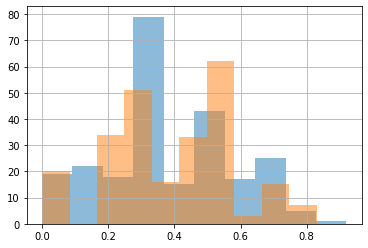

<IPython.core.display.Javascript object>

In [32]:
some_visits["access"].hist(alpha=0.5)
no_visits["access"].hist(alpha=0.5)

Could have difference

In [33]:
stats.describe(some_visits["access"])



DescribeResult(nobs=244, minmax=(0.0, 0.92), mean=0.38483606557377054, variance=0.03424565202725494, skewness=-0.011521438402813973, kurtosis=-0.32227474416845725)

<IPython.core.display.Javascript object>

In [34]:
stats.describe(no_visits["access"])

DescribeResult(nobs=241, minmax=(0.0, 0.83), mean=0.37746887966804976, variance=0.03514815006915629, skewness=-0.132195453705465, kurtosis=-0.5139633830094423)

<IPython.core.display.Javascript object>

In [35]:
stats.ttest_ind(no_visits["access"], some_visits["access"])

Ttest_indResult(statistic=-0.43551828384135033, pvalue=0.6633808282596757)

<IPython.core.display.Javascript object>

High p value implies access to healthcare does not necessarily incentivize visiting the doctor.

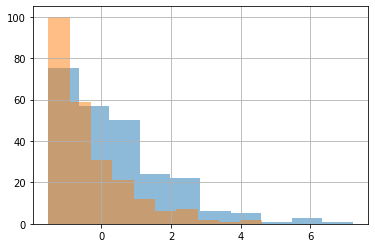

<IPython.core.display.Javascript object>

In [36]:
some_visits["health"].hist(alpha=0.5)
no_visits["health"].hist(alpha=0.5)

In [37]:
stats.mannwhitneyu(some_visits["health"], no_visits["health"])

MannwhitneyuResult(statistic=19667.0, pvalue=1.3789731847394476e-10)

<IPython.core.display.Javascript object>

In [38]:
cles_ind(some_visits["health"], no_visits["health"])

0.6552785524794231

<IPython.core.display.Javascript object>

In [39]:
rbc_ind(some_visits["health"], no_visits["health"])

0.3310999251751582

<IPython.core.display.Javascript object>

In [26]:
docs.head()

,doctor,children,access,health,access_groups
0,0,1,0.50,0.495,True
1,1,3,0.17,0.520,False
2,0,4,0.42,-1.227,True
3,0,2,0.33,-1.524,False
4,11,1,0.67,0.173,True


<IPython.core.display.Javascript object>

In [43]:
docs.boxplot(by="access_groups")

AttributeError: 'Series' object has no attribute 'boxplot'

<IPython.core.display.Javascript object>